In [ ]:

!pip install scikit-optimize

In [ ]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, make_scorer, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from numpy.lib.stride_tricks import sliding_window_view


from skopt import BayesSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

from sklearn.neural_network import MLPRegressor

---
## Preprocesado  
---
Identico al del de Treball Previ añadiendo requisitos especificos de MLP (estandarización y one-hot)

In [ ]:
time_for_pred = 24

In [ ]:
# Cargar el conjunto de datos
data = pd.read_csv('dataset.csv')

# Crear características 'lagged'
for i in range(1, 2):
    data[f'lag_{i}'] = data['exits'].shift(i)

data['demand_satisfied_lag'] = data['demand_satisfied'].shift(1)
data = data.drop('demand_satisfied', axis=1)

# Crear una columna de fecha a partir de las columnas de año, mes y día
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])

# Filtrar datos entre las fechas especificadas
start_date = pd.Timestamp('2022-01-01')
end_date = pd.Timestamp('2023-11-30')
data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

data = data.drop('date', axis=1)

In [ ]:
split_index = int(len(data) - time_for_pred)

# Divide los datos en conjuntos de entrenamiento y prueba según el índice calculado
data_train = data.iloc[:split_index]
data_test = data.iloc[split_index:]


data_train.shape, data_test.shape

((16752, 17), (24, 17))

In [ ]:
from sklearn.impute import KNNImputer
data_imputer = data_train.drop('exits', axis=1)

knni_demand_satisfied_lag = KNNImputer(n_neighbors=10)
knni_initial_bikes = KNNImputer(n_neighbors=10)

i_demand_satisfied_lag = knni_demand_satisfied_lag.fit_transform(data_imputer)[:,-1]
i_initial_bikes = knni_initial_bikes.fit_transform(data_imputer)[:, 13]

# Redondear y convertir a enteros las columnas
i_demand_satisfied_lag = i_demand_satisfied_lag.round().astype(int)
i_initial_bikes = i_initial_bikes.round().astype(int)

data_train['demand_satisfied_lag'] = i_demand_satisfied_lag
data_train['initial_bikes'] = i_initial_bikes

<ipython-input-8-dab25ab3a451>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['demand_satisfied_lag'] = i_demand_satisfied_lag
<ipython-input-8-dab25ab3a451>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['initial_bikes'] = i_initial_bikes


In [ ]:
data_imputer = data_test.drop('exits', axis=1)

i_demand_satisfied_lag = knni_demand_satisfied_lag.transform(data_imputer)[:,-1]
i_initial_bikes = knni_initial_bikes.transform(data_imputer)[:, 13]

# Redondear y convertir a enteros las columnas
i_demand_satisfied_lag = i_demand_satisfied_lag.round().astype(int)
i_initial_bikes = i_initial_bikes.round().astype(int)

data_test['demand_satisfied_lag'] = i_demand_satisfied_lag
data_test['initial_bikes'] = i_initial_bikes

<ipython-input-9-39500e2f055e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['demand_satisfied_lag'] = i_demand_satisfied_lag
<ipython-input-9-39500e2f055e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['initial_bikes'] = i_initial_bikes


---
# **MLP**
---



In [ ]:
results_df = pd.DataFrame(columns=['Model', 'R2 Score', 'MSE', 'RMSE', 'MAE'])

In [ ]:
from sklearn.preprocessing import StandardScaler

data = pd.concat([data_train, data_test], ignore_index=True)

# Select the categorical variables for one-hot encoding
categorical_vars_selected = ["hour", "day", "month", "year", "week_day", "working_day", "class_day","demand_satisfied_lag"]

# Perform one-hot encoding on the selected categorical variables
data_mlp = pd.get_dummies(data, columns=categorical_vars_selected)

data_mlp.head()


data_train_mlp = data_mlp.iloc[:split_index]
data_test_mlp = data_mlp.iloc[split_index:]

numeric_vars_without_exits = ["temperature", "a_temperature", "precipitation", "wind_speed", "humidity","initial_bikes","lag_1"]

scaler = StandardScaler()

data_train_mlp[numeric_vars_without_exits] = scaler.fit_transform(data_train_mlp[numeric_vars_without_exits])
data_test_mlp[numeric_vars_without_exits] = scaler.transform(data_test_mlp[numeric_vars_without_exits])

X_train_mlp = data_train_mlp.drop('exits', axis=1)
y_train_mlp = data_train_mlp['exits']

X_test_mlp = data_test_mlp.drop('exits', axis=1)
y_test_mlp = data_test_mlp['exits']

<ipython-input-11-64bdc20f5ac8>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train_mlp[numeric_vars_without_exits] = scaler.fit_transform(data_train_mlp[numeric_vars_without_exits])
<ipython-input-11-64bdc20f5ac8>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_mlp[numeric_vars_without_exits] = scaler.transform(data_test_mlp[numeric_vars_without_exits])


In [ ]:
from cmath import sqrt
# Define the parameter search space for MLP
param_space_mlp = {
    'hidden_layer_sizes': [20,50,100],
    'activation': ['relu', 'tanh'],
    'solver' : ['lbfgs','adam'],
    'alpha': [0.00005, 0.0001, 0.0002],
    'learning_rate': ['constant','adaptive'],
    'max_iter': [100,200,300],
    'shuffle' : [False]
}

# Create the MLP model
mlp = MLPRegressor(max_iter=1000)

# Configure TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=3, gap=25)

# Configure BayesSearchCV for MLP
mlp_bs = BayesSearchCV(
    mlp,
    param_space_mlp,
    n_iter=30,
    cv=tscv,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    n_jobs=-1,
    refit=True,
    random_state=0
)

# Fit the MLP model with BayesSearchCV
mlp_bs.fit(X_train_mlp, y_train_mlp)

# Best model and parameters found
best_mlp = mlp_bs.best_estimator_
best_params_mlp = mlp_bs.best_params_

# Evaluate the model on the test set
y_pred_mlp = best_mlp.predict(X_test_mlp)
r2_score_mlp = r2_score(y_test_mlp, y_pred_mlp)

# Print the best parameters and R2 score for MLP with BayesSearchCV
print("Best parameters for MLP (BayesSearchCV):", best_params_mlp)
mse_mlp = mean_squared_error(y_test_mlp, y_pred_mlp)
mae_mlp = mean_absolute_error(y_test_mlp, y_pred_mlp)

# Assuming you have a DataFrame named results_df
results_df.loc[len(results_df)] = ["MLP", r2_score_mlp, mse_mlp, sqrt(mse_mlp), mae_mlp]

# Print or use results_df as needed
print(results_df)

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best parameters for MLP (BayesSearchCV): OrderedDict([('activation', 'relu'), ('alpha', 0.0002), ('hidden_layer_sizes', 100), ('learning_rate', 'constant'), ('max_iter', 100), ('shuffle', False), ('solver', 'adam')])
  Model  R2 Score       MSE                RMSE       MAE
0   MLP  0.836215  5.197622  2.279829+0.000000j  1.416257


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
results_df

,Model,R2 Score,MSE,RMSE,MAE
0,MLP,0.836215,5.197622,2.279829+0.000000j,1.416257


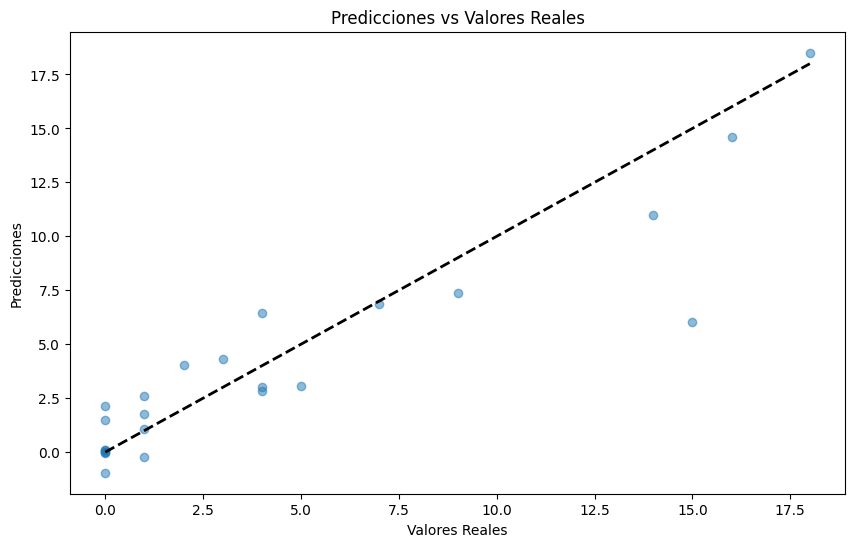

In [ ]:
# Realizar el gráfico de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test_mlp, y_pred_mlp, alpha=0.5)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.plot([y_test_mlp.min(), y_test_mlp.max()], [y_test_mlp.min(), y_test_mlp.max()], 'k--', lw=2)  # Línea de perfecta predicción
plt.show();

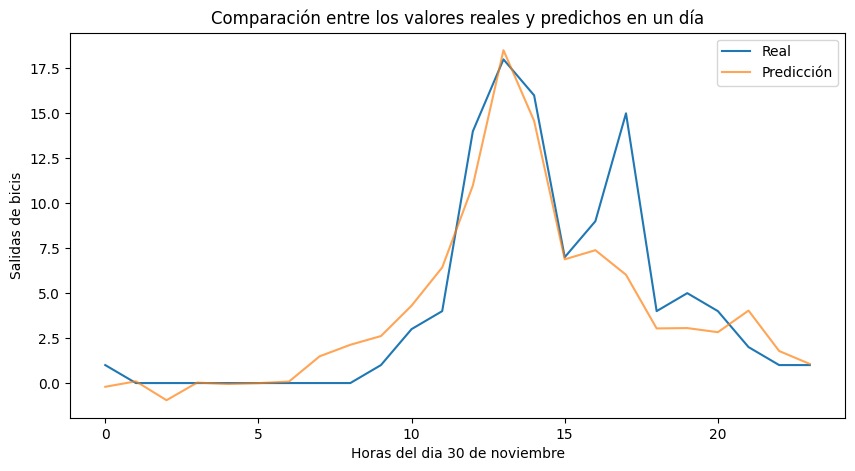

In [ ]:
# Graficar los valores reales vs. los predichos
plt.figure(figsize=(10, 5))
plt.plot(y_test_mlp.reset_index(drop=True), label='Real')
plt.plot(y_pred_mlp, label='Predicción', alpha=0.7)
plt.title('Comparación entre los valores reales y predichos en un día')
plt.xlabel('Horas del dia 30 de noviembre')
plt.ylabel('Salidas de bicis')
plt.legend()
plt.show();

Ver la importancia de características:

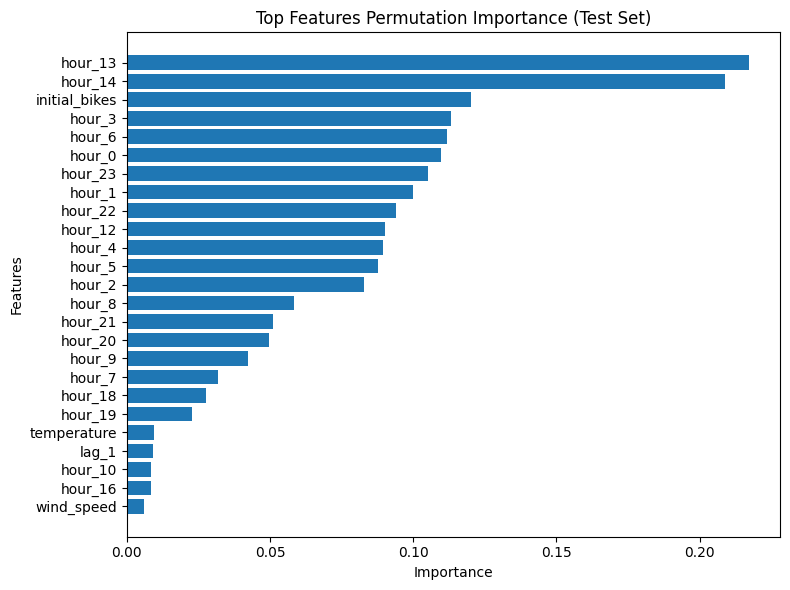

In [ ]:
from sklearn.inspection import permutation_importance

# Calcular la importancia de la permutación
perm_importance = permutation_importance(best_mlp, X_test_mlp, y_test_mlp, n_repeats=10, random_state=0, n_jobs=-1)

# Obtener las importancias medias y los índices de las características ordenadas por importancia
importances_mean = perm_importance.importances_mean
sorted_idx = np.argsort(importances_mean)

# Seleccionar un número específico de las características más importantes para mostrar
num_features_to_show = 25  # Ajusta este número según sea necesario
sorted_indices = np.argsort(importances_mean)[-num_features_to_show:]

# Visualizar la importancia de las características
plt.figure(figsize=(8, 6))  # Ajusta el tamaño del gráfico según sea necesario
plt.barh(range(len(sorted_indices)), importances_mean[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), np.array(X_train_mlp.columns)[sorted_indices])
plt.title('Top Features Permutation Importance (Test Set)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()  # Ajustar automáticamente los parámetros para que el gráfico quede bien
plt.show()